In [ ]:
import keras.backend as K
from keras.layers import Layer, RNN
from keras.utils import tf_utils
import tensorflow_datasets as tfds
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, Dense
from tensorflow.keras.initializers import GlorotUniform, Orthogonal, Zeros
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
import numpy as np
import os

In [ ]:
!pip install wget
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-11-28 11:40:42--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-11-28 11:40:42--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-11-28 11:40:43--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [ ]:
VOCAB_SIZE = 2000
OOV = "<OOV>"
MAX_SEQUENCE_LENGTH = 1000
EMBEDDING_DIM = 300
BATCH = 32
LEARNING_RATE = 0.001
EPOCHS = 10
GLOVE_FILE = os.path.join('./', f'glove.6B.{EMBEDDING_DIM}d.txt')

In [ ]:
imdb = tfds.load('imdb_reviews', as_supervised=True)
train, test = imdb['train'], imdb['test']
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV)

In [ ]:
training_sentences=[]
training_labels=[]
testing_sentences=[]
testing_labels=[]
for sentence,label in train:
    training_sentences.append(str(sentence.numpy()))
    training_labels.append(label.numpy())
for sentence,label in test:
    testing_sentences.append(str(sentence.numpy()))
    testing_labels.append(label.numpy())
training_labels_final=np.array(training_labels)
testing_labels_final=np.array(testing_labels)

In [ ]:
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
training_sequences=tokenizer.texts_to_sequences(training_sentences)
testing_sequences=tokenizer.texts_to_sequences(testing_sentences)
training_padded=pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)
testing_padded=pad_sequences(testing_sequences, maxlen=MAX_SEQUENCE_LENGTH)
train_dataset = tf.data.Dataset.from_tensor_slices((training_padded, training_labels_final))
test_dataset = tf.data.Dataset.from_tensor_slices((testing_padded, testing_labels_final))
train_dataset = train_dataset.batch(BATCH, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH, drop_remainder=True)

In [ ]:
embeddings_index = {}
with open(GLOVE_FILE) as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embeddings_index[word] = coefs

In [ ]:
num_words = min(VOCAB_SIZE, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
  if i > VOCAB_SIZE: continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
class ELSTMCell(Layer):
  def __init__(self, units, epochs, **kwargs):
    self.state_size = [units, units]
    self.units = units
    self.h_sp = tf.Variable(
        [[.0] * units for _ in range(units)], trainable=False)
    self.exp_sum = tf.Variable(
        [[.0] * units for _ in range(units)], trainable=False)
    self.e_t = tf.Variable(
        [[.0] * units for _ in range(units)], dtype=tf.float64, trainable=False)
    self.ro_min = tf.Variable(.0001, dtype=tf.float64, trainable=False)
    self.ro_max = tf.Variable(.01, dtype=tf.float64, trainable=False)
    self.cur_epoch = tf.Variable(1, dtype=tf.float64, trainable=False)
    self.epochs = epochs
    super(ELSTMCell, self).__init__(**kwargs)

  def get_config(self):
    config = super().get_config()
    config.update({
        "units": self.units,
        "epochs": self.epochs
    })
    return config

  def set_current_epoch(self, val):
    self.cur_epoch.assign(val)

  def clear_accumulators(self):
    self.h_sp.assign([[.0] * self.units for _ in range(self.units)])
    self.exp_sum.assign([[.0] * self.units for _ in range(self.units)])
    self.e_t.assign([[.0] * self.units for _ in range(self.units)])

  @tf_utils.shape_type_conversion
  def build(self, input_shape):
    input_dim = input_shape[-1]

    self.kernel = self.add_weight(shape=(input_dim, self.units * 4),
                                  name='kernel',
                                  initializer=GlorotUniform())

    self.recurrent_kernel = self.add_weight(shape=(self.units, self.units * 4),
                                            name='recurrent_kernel',
                                            initializer=Orthogonal())

    self.bias = self.add_weight(shape=(self.units * 4,),
                                name='bias',
                                initializer=Zeros())

    self.built = True

  @tf.function
  def call(self, inputs, states, training=None):
    h_tm1 = states[0]
    c_tm1 = states[1]

    self.exp_sum.assign_add(tf.math.exp(tf.transpose(h_tm1) * self.h_sp))
    inputs_i = inputs
    inputs_f = inputs
    inputs_c = inputs
    inputs_o = inputs

    k_i, k_f, k_c, k_o = tf.split(
        self.kernel, num_or_size_splits=4, axis=1)

    x_i = K.dot(inputs_i, k_i)
    x_f = K.dot(inputs_f, k_f)
    x_c = K.dot(inputs_c, k_c)
    x_o = K.dot(inputs_o, k_o)

    b_i, b_f, b_c, b_o = tf.split(self.bias, num_or_size_splits=4, axis=0)

    x_i = K.bias_add(x_i, b_i)
    x_f = K.bias_add(x_f, b_f)
    x_c = K.bias_add(x_c, b_c)
    x_o = K.bias_add(x_o, b_o)

    h_tm1_i = h_tm1
    h_tm1_f = h_tm1
    h_tm1_c = h_tm1
    h_tm1_o = h_tm1

    x = (x_i, x_f, x_c, x_o)
    h_tm1 = (h_tm1_i, h_tm1_f, h_tm1_c, h_tm1_o)

    c, o = self._compute_carry_and_output(x, h_tm1, c_tm1)
    self.h_sp.assign_add(states[0])
    h = o * tf.keras.activations.tanh(c)

    return h, [h, c]

  @tf.function
  def _compute_carry_and_output(self, x, h_tm1, c_tm1):
    x_i, x_f, x_c, x_o = x
    h_tm1_i, h_tm1_f, h_tm1_c, h_tm1_o = h_tm1

    i = tf.keras.activations.hard_sigmoid(
      x_i + K.dot(h_tm1_i, self.recurrent_kernel[:, :self.units]))

    es = self.emotion_estimator(h_tm1_i)
    self.emotion_modulator(x_o, es)
    f = tf.keras.activations.hard_sigmoid(x_f + K.dot(
      h_tm1_f, self.recurrent_kernel[:, self.units:self.units * 2]))
    f = tf.cast(self.e_t, dtype=tf.float32) * f
    o = tf.keras.activations.hard_sigmoid(
      x_o + K.dot(h_tm1_o, self.recurrent_kernel[:, self.units * 3:]))
    a = tf.keras.activations.tanh(x_c + K.dot(
      h_tm1_c, self.recurrent_kernel[:, self.units * 2:self.units * 3]))

    c = f * c_tm1 + i * a
    return c, o

  @tf.function
  def emotion_estimator(self, h_t):
    exp_new = tf.math.exp(tf.transpose(h_t) * self.h_sp)
    p = exp_new / self.exp_sum
    return tf.math.reduce_mean(p) > .3

  @tf.function
  def emotion_modulator(self, x_o, es):
    to_f64 = lambda x: tf.cast(x, dtype=tf.float64)
    ro_dif = self.ro_max - self.ro_min
    ep = (self.epochs - self.cur_epoch) / self.epochs
    ro = to_f64(ro_dif) * ep + self.ro_min
    ro_h = ro * to_f64(tf.math.abs(x_o - self.h_sp))
    if es: self.e_t.assign(self.e_t + ro_h)
    else: self.e_t.assign(self.e_t - ro_h)
    self.normalize_e_t()

  @tf.function
  def normalize_e_t(self):
    min_e = tf.reduce_min(self.e_t)
    max_e = tf.reduce_max(self.e_t)
    if max_e > min_e:
      normalized = 2. * (self.e_t - min_e) / (max_e - min_e) - 1.
      self.e_t.assign(normalized)

In [ ]:
class EpochSetterCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs=None):
    for l in self.model.layers:
      if isinstance(l, RNN):
        l.cell.clear_accumulators()
        l.cell.set_current_epoch(epoch)

In [ ]:
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [ ]:
model = Sequential([
  embedding_layer,
  Conv1D(32, 4, padding='same', activation='relu'),
  MaxPooling1D(4),
  RNN(ELSTMCell(BATCH, EPOCHS)),
  Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(LEARNING_RATE),
              metrics=['accuracy'])

In [ ]:
def lr_time_based_decay(epoch, lr):
  return lr * 1 / (1 + LEARNING_RATE / EPOCHS * epoch)

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=(test_dataset),
    callbacks=[
      tf.keras.callbacks.LearningRateScheduler(lr_time_based_decay),
      EpochSetterCallback()
    ]
)

Epoch 1/10
781/781 [==============================] - 859s 1s/step - loss: 0.5394 - accuracy: 0.7231 - val_loss: 0.4442 - val_accuracy: 0.7983 - lr: 0.0010
Epoch 2/10
781/781 [==============================] - 848s 1s/step - loss: 0.4120 - accuracy: 0.8166 - val_loss: 0.3703 - val_accuracy: 0.8442 - lr: 9.9990e-04
Epoch 3/10
781/781 [==============================] - 847s 1s/step - loss: 0.5248 - accuracy: 0.7408 - val_loss: 0.3818 - val_accuracy: 0.8353 - lr: 9.9970e-04
Epoch 4/10
781/781 [==============================] - 843s 1s/step - loss: 0.4576 - accuracy: 0.7913 - val_loss: 0.3788 - val_accuracy: 0.8361 - lr: 9.9940e-04
Epoch 5/10
781/781 [==============================] - 846s 1s/step - loss: 0.3594 - accuracy: 0.8456 - val_loss: 0.3494 - val_accuracy: 0.8490 - lr: 9.9900e-04
Epoch 6/10
781/781 [==============================] - 847s 1s/step - loss: 0.4439 - accuracy: 0.7993 - val_loss: 0.4555 - val_accuracy: 0.7943 - lr: 9.9850e-04
Epoch 7/10
781/781 [========================

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
model.save('/content/gdrive/MyDrive/model1', save_format='tf')

Mounted at /content/gdrive
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/model1/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/model1/assets


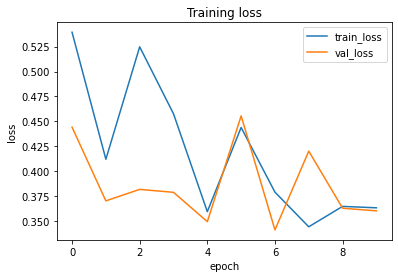

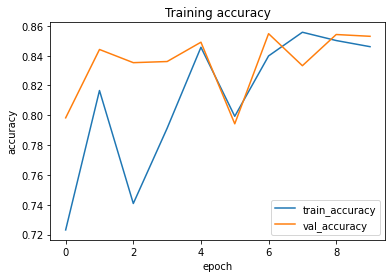

In [ ]:
import matplotlib.pyplot as plt

def plot(train_data, val_data, loss=True):
	title = 'loss' if loss else 'accuracy'
	plt.figure()
	plt.title(f'Training {title}')
	plt.xlabel('epoch')
	plt.ylabel(title)
	plt.plot(train_data, label=f'train_{title}')
	plt.plot(val_data, label=f'val_{title}')
	plt.legend()
	plt.show()
 
plot(history.history['loss'], history.history['val_loss'])
plot(history.history['accuracy'], history.history['val_accuracy'], loss=False)

In [ ]:
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=(test_dataset),
    callbacks=[
      tf.keras.callbacks.LearningRateScheduler(lr_time_based_decay),
      EpochSetterCallback()
    ]
)

Epoch 1/5
781/781 [==============================] - 855s 1s/step - loss: 0.3957 - accuracy: 0.8234 - val_loss: 0.3528 - val_accuracy: 0.8586 - lr: 9.9551e-04
Epoch 2/5
781/781 [==============================] - 858s 1s/step - loss: 0.3057 - accuracy: 0.8765 - val_loss: 0.3616 - val_accuracy: 0.8533 - lr: 9.9541e-04
Epoch 3/5
781/781 [==============================] - 856s 1s/step - loss: 0.3306 - accuracy: 0.8604 - val_loss: 0.4355 - val_accuracy: 0.7889 - lr: 9.9521e-04
Epoch 4/5
781/781 [==============================] - 853s 1s/step - loss: 0.2937 - accuracy: 0.8788 - val_loss: 0.3316 - val_accuracy: 0.8573 - lr: 9.9491e-04
Epoch 5/5
781/781 [==============================] - 854s 1s/step - loss: 0.2826 - accuracy: 0.8860 - val_loss: 0.3327 - val_accuracy: 0.8625 - lr: 9.9452e-04


In [ ]:
model.save('/content/gdrive/MyDrive/model2', save_format='tf')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/model2/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/model2/assets
